In [9]:
import json
from enum import Enum
from rdkit import Chem
from pydantic import BaseModel
from typing import List

In [10]:
# Define atom type enum
class AtomTypeEnum(str, Enum):
    H = "H"
    C = "C"
    N = "N"
    O = "O"
    F = "F"

In [11]:
# Define Bond model
class Bond(BaseModel):
    atom: 'Atom'
    bond_type: str

# Define Atom model
class Atom(BaseModel):
    atom_id: int
    atom_type: AtomTypeEnum
    bonds: List[Bond]

In [7]:
# Needed to resolve forward references in Pydantic
Bond.update_forward_refs()

/var/folders/z1/tgqk7h7909s6y4mnlllzyf_h0000gp/T/ipykernel_34256/3570181828.py:2: PydanticDeprecatedSince20: The `update_forward_refs` method is deprecated; use `model_rebuild` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  Bond.update_forward_refs()


In [7]:
def smiles_to_tree(atom_format, bond_format, atom_type_enum, smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    atom_idx_to_atom = {}
    visited_atoms = set()
    queue = []
    added_bonds = set([])

    # Initialize with the first atom
    for atom in mol.GetAtoms():
        if atom.GetIdx() == 0:
            atom_molecule = atom_format(atom_id=atom.GetIdx(),
                                        atom_type=atom_type_enum(atom.GetSymbol()),
                                        bonds=[])
            atom_idx_to_atom[atom.GetIdx()] = atom_molecule
            queue.append((None, atom.GetIdx(), None))
            break

    # Process the queue using BFS
    while queue:
        parent_idx, current_idx, bond_type = queue.pop(0)
        current_atom = atom_idx_to_atom[current_idx]
        if parent_idx is not None:
            if current_idx in visited_atoms:
                current_atom = atom_format(atom_id=current_idx,
                                           atom_type=atom_type_enum(mol.GetAtomWithIdx(current_idx).GetSymbol()),
                                           bonds=[])
            parent_atom = atom_idx_to_atom[parent_idx]
            bond = bond_format(atom=current_atom, bond_type=bond_type)
            parent_atom.bonds.append(bond)
            visited_atoms.add(current_idx)
            visited_atoms.add(parent_idx)

        for bond in mol.GetAtomWithIdx(current_idx).GetBonds():
            neighbor_idx = bond.GetOtherAtomIdx(current_idx)
            if (current_idx, neighbor_idx) not in added_bonds and (neighbor_idx, current_idx) not in added_bonds:
                neighbor_bond_type = str(bond.GetBondType()).replace("BondType.", "")
                if neighbor_bond_type == "DATIVE":
                    neighbor_bond_type = "SINGLE"
                if neighbor_idx not in atom_idx_to_atom:
                    neighbor_atom = atom_format(atom_id=neighbor_idx,
                                                atom_type=atom_type_enum(mol.GetAtomWithIdx(neighbor_idx).GetSymbol()),
                                                bonds=[])
                    atom_idx_to_atom[neighbor_idx] = neighbor_atom
                queue.append((current_idx, neighbor_idx, neighbor_bond_type))
                added_bonds.add((current_idx, neighbor_idx))

    return atom_idx_to_atom[0]


In [14]:
# Custom JSON serializer for Enum
def custom_json_serializer(obj):
    if isinstance(obj, Enum):
        return obj.value
    raise TypeError("Type not serializable")

In [5]:
import pandas as pd

data = pd.read_csv("./dataset/qm9.csv")
smiles_list = data['SMILES1'].tolist()
smiles_list[:10]

['C', 'N', 'O', 'C#C', 'C#N', 'C=O', 'CC', 'CO', 'CC#C', 'CC#N']

In [12]:
mol_tree_list = []
for smiles in smiles_list:
    mol_tree = smiles_to_tree(Atom, Bond, AtomTypeEnum, smiles)
    mol_tree_list.append(mol_tree)

In [17]:
molecule_json = json.dumps([mol.dict() for mol in mol_tree_list], indent=2, default=custom_json_serializer)

/tmp/ipykernel_62274/731948994.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  molecule_json = json.dumps([mol.dict() for mol in mol_tree_list], indent=2, default=custom_json_serializer)


In [18]:
with open("./outputs/mol2json.json", "w") as f:
    f.write(molecule_json)

In [2]:
smiles = "C1=CC1"  # Cyclopropane with a hydroxymethyl group
molecule = smiles_to_tree(Atom, Bond, AtomTypeEnum, smiles)

type(molecule)

NameError: name 'smiles_to_tree' is not defined

In [13]:
molecule_json = json.dumps(molecule.dict(), indent=2, default=custom_json_serializer)
molecule_json

/var/folders/z1/tgqk7h7909s6y4mnlllzyf_h0000gp/T/ipykernel_34256/3890830084.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  molecule_json = json.dumps(molecule.dict(), indent=2, default=custom_json_serializer)


'{\n  "atom_id": 0,\n  "atom_type": "C",\n  "bonds": [\n    {\n      "atom": {\n        "atom_id": 1,\n        "atom_type": "C",\n        "bonds": [\n          {\n            "atom": {\n              "atom_id": 2,\n              "atom_type": "C",\n              "bonds": []\n            },\n            "bond_type": "SINGLE"\n          }\n        ]\n      },\n      "bond_type": "DOUBLE"\n    },\n    {\n      "atom": {\n        "atom_id": 2,\n        "atom_type": "C",\n        "bonds": []\n      },\n      "bond_type": "SINGLE"\n    }\n  ]\n}'

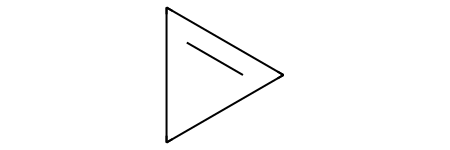

In [14]:
smiles = "C1=CC1"  # Cyclopropane with a hydroxymethyl group
Chem.MolFromSmiles(smiles)

In [16]:
smiles2 = "C1(CO)C1"
Chem.MolFromSmiles(smiles2)

[19:53:05] SMILES Parse Error: ring closure 1 duplicates bond between atom 0 and atom 3 for input: 'C1(CO)C1'
